The question that I try to answer here, is to find a simple model to predict truck travelled distance between two locations based on the shortest distance between them. The data that we have is a csv file of the location of plants, a csv file of customer's location. A csv file of historic travels between plants and customers. We want to predict the distance for those pairs we do not have data for.


## Import libraries

In [1]:
import pandas as pd
import numpy as np

from geopy.distance import distance
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold, cross_val_predict

## Import data files

In [2]:
plants = pd.read_csv('plants2.csv')
plants.head()

,plant,lat_plant,lon_plant
0,plant_1,42.142478,-82.767944
1,plant_2,34.240845,-91.383426
2,plant_3,32.765674,-92.726484
3,plant_4,34.761577,-98.483023
4,plant_5,33.125264,-99.225366


In [3]:
customers = pd.read_csv('customers2.csv')
customers.head()

,customer,lat_cust,lon_cust,cust_loc
0,customer_1,33.119610,-97.400205,"[-97.40020548679664, 33.119610297337566]"
1,customer_2,34.045329,-104.146559,"[-104.14655867535417, 34.045328769219594]"
2,customer_3,38.008776,-81.852771,"[-81.85277146802052, 38.00877605660633]"
3,customer_4,33.648772,-86.025302,"[-86.02530175312035, 33.648771968569385]"
4,customer_5,32.648383,-104.643170,"[-104.64316989524293, 32.64838291798267]"


In [4]:
df = pd.read_csv('historic_data.csv')
df.head()

,plant,customer,distance
0,plant_1,customer_1,843.18
1,plant_1,customer_2,1252.82
2,plant_1,customer_5,1304.46
3,plant_1,customer_14,901.05
4,plant_1,customer_15,510.35


## Data cleaning

Let's find average of historic milages and add the location of plants and customers

In [5]:
df = df.merge(plants, left_on='plant', right_on='plant')
df.head()

,plant,customer,distance,lat_plant,lon_plant
0,plant_1,customer_1,843.18,42.142478,-82.767944
1,plant_1,customer_2,1252.82,42.142478,-82.767944
2,plant_1,customer_5,1304.46,42.142478,-82.767944
3,plant_1,customer_14,901.05,42.142478,-82.767944
4,plant_1,customer_15,510.35,42.142478,-82.767944


In [6]:
df = df.merge(customers, left_on='customer', right_on='customer')
df.head()

,plant,customer,distance,lat_plant,lon_plant,lat_cust,lon_cust,cust_loc
0,plant_1,customer_1,843.18,42.142478,-82.767944,33.119610,-97.400205,"[-97.40020548679664, 33.119610297337566]"
1,plant_3,customer_1,426.32,32.765674,-92.726484,33.119610,-97.400205,"[-97.40020548679664, 33.119610297337566]"
2,plant_5,customer_1,160.12,33.125264,-99.225366,33.119610,-97.400205,"[-97.40020548679664, 33.119610297337566]"
3,plant_10,customer_1,994.55,36.172684,-84.722734,33.119610,-97.400205,"[-97.40020548679664, 33.119610297337566]"
4,plant_1,customer_2,1252.82,42.142478,-82.767944,34.045329,-104.146559,"[-104.14655867535417, 34.045328769219594]"


In [7]:
df.shape

(450, 8)

In [12]:
df.drop(columns=['cust_loc'], inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450 entries, 0 to 449
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   plant         450 non-null    object 
 1   customer      450 non-null    object 
 2   distance      450 non-null    float64
 3   lat_plant     450 non-null    float64
 4   lon_plant     450 non-null    float64
 5   lat_cust      450 non-null    float64
 6   lon_cust      450 non-null    float64
 7   geo_distance  450 non-null    float64
dtypes: float64(6), object(2)
memory usage: 47.8+ KB


Lets find the shortest distance between points by using distance from geopy

In [18]:
## Lets find geodesc distance
df['geo_distance'] = np.nan
for index, row in df.iterrows():
    point1 = [row['lat_plant'], row['lon_plant']]
    point2 = [row['lat_cust'], row['lon_cust']]
    df.loc[index,'geo_distance'] = distance(point1, point2).miles

In [19]:
df.head(4)

,plant,customer,distance,lat_plant,lon_plant,lat_cust,lon_cust,geo_distance
0,plant_1,customer_1,843.18,42.142478,-82.767944,33.11961,-97.400205,1013.066488
1,plant_3,customer_1,426.32,32.765674,-92.726484,33.11961,-97.400205,272.644352
2,plant_5,customer_1,160.12,33.125264,-99.225366,33.11961,-97.400205,105.838246
3,plant_10,customer_1,994.55,36.172684,-84.722734,33.11961,-97.400205,751.577091


Text(0, 0.5, 'Distance (mile)')

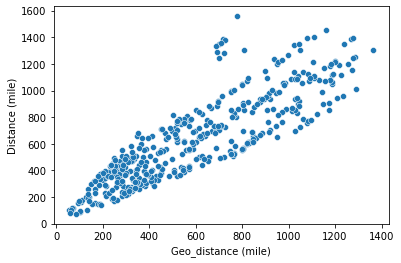

In [51]:
gig, ax = plt.subplots()
sns.scatterplot(y=df['distance'], x=df['geo_distance'], ax=ax)
ax.set_xlabel('Geo_distance (mile)')
ax.set_ylabel('Distance (mile)')

## Model training

We split the data into two sets, training and test. Then use cross-validation with 5 fold to do a regression. we then find R2 and mean MAE

In [22]:
X = df['geo_distance'].values.reshape(-1, 1)
y = df['distance'].values.reshape(-1, 1)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [25]:
model = LinearRegression()
kfold = KFold(n_splits=5, shuffle = False)

cv_results = cross_validate(model, X_train, y_train, cv = kfold, scoring='neg_mean_squared_error')
cv_scores = cv_results['test_score']
print(cv_scores)
print(np.mean(cv_scores), np.std(cv_scores))

[-32674.48311549 -19450.39304826 -32871.74686925 -25705.30239037
 -30105.64139251]
-28161.51336317426 5064.571431924511


In [26]:
final_model = model.fit(X_train, y_train)

In [27]:
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

train_r2 = round(r2_score(y_train, y_train_pred), 2)
test_r2 = round(r2_score(y_test, y_test_pred), 2)
print('train R2:', train_r2)
print('test R2: ', test_r2)

train R2: 0.73
test R2:  0.76


The R2 for test and train are very similar. The model is not overfitting. Let's use it to predict the distance between plants and customers. But first lets see what pair we don't have data for.

In [28]:
df['plant_customer'] = [str(x) + '**' + str(y) for x, y in zip(df['plant'], df['customer'])]

In [29]:
all_pair = []
for plant_name in plants['plant'].unique():
    for customer in customers['customer']:
        pair = plant_name + '**' + customer
        all_pair.append(pair)

In [30]:
len(all_pair)

2500

In [31]:
unavailable_pairs = list(set(all_pair) - set(all_pair).intersection(set(df['plant_customer'])))

In [32]:
len(unavailable_pairs)

2050

In [33]:
unavailable = pd.DataFrame()

In [34]:
unavailable['plant'] = [pair.split('**')[0] for pair in unavailable_pairs]
unavailable['customer'] = [pair.split('**')[1] for pair in unavailable_pairs]
unavailable.head()

,plant,customer
0,plant_4,customer_245
1,plant_4,customer_116
2,plant_3,customer_120
3,plant_7,customer_6
4,plant_6,customer_142


In [35]:
unavailable = unavailable.merge(plants, on='plant', how='left')
unavailable = unavailable.merge(customers, on='customer', how='left')


In [36]:
unavailable.head()

,plant,customer,lat_plant,lon_plant,lat_cust,lon_cust,cust_loc
0,plant_4,customer_245,34.761577,-98.483023,42.932752,-84.496640,"[-84.496640102917, 42.93275202627165]"
1,plant_4,customer_116,34.761577,-98.483023,32.772071,-88.080394,"[-88.08039406501419, 32.77207117467964]"
2,plant_3,customer_120,32.765674,-92.726484,34.653580,-89.765890,"[-89.76589028212442, 34.65358031965204]"
3,plant_7,customer_6,33.955302,-100.491126,37.595152,-82.043794,"[-82.04379370309694, 37.59515182696723]"
4,plant_6,customer_142,35.282113,-89.584722,35.618365,-82.429394,"[-82.42939436550455, 35.61836505106709]"


In [37]:

unavailable['geo_distance'] = np.nan
for index, row in unavailable.iterrows():
    
    point1 = [row['lat_plant'], row['lon_plant']]
    point2 = [row['lat_cust'], row['lon_cust']]
    unavailable.loc[index,'geo_distance'] = distance(point1, point2).miles

In [38]:
X = unavailable['geo_distance'].values.reshape(-1,1)
 

In [39]:
prediction = final_model.predict(X)

In [40]:
unavailable['distance'] = prediction

In [41]:
unavailable.head()

,plant,customer,lat_plant,lon_plant,lat_cust,lon_cust,cust_loc,geo_distance,distance
0,plant_4,customer_245,34.761577,-98.483023,42.932752,-84.496640,"[-84.496640102917, 42.93275202627165]",939.655293,932.541130
1,plant_4,customer_116,34.761577,-98.483023,32.772071,-88.080394,"[-88.08039406501419, 32.77207117467964]",613.974384,649.908858
2,plant_3,customer_120,32.765674,-92.726484,34.653580,-89.765890,"[-89.76589028212442, 34.65358031965204]",214.481657,303.221244
3,plant_7,customer_6,33.955302,-100.491126,37.595152,-82.043794,"[-82.04379370309694, 37.59515182696723]",1064.454870,1040.844648
4,plant_6,customer_142,35.282113,-89.584722,35.618365,-82.429394,"[-82.42939436550455, 35.61836505106709]",404.217369,467.877611


In [42]:
for_submit = unavailable[['plant', 'customer', 'distance']]

In [43]:
for_submit.to_excel('report.xlsx', index=False)

## Robust Regression

[-30161.88644584 -36063.00507381 -36710.51230213 -36404.3894391
 -42912.56806969]
-36450.472266113764 4037.9417793216076
train R2: 0.73
test R2:  0.76


Text(0, 0.5, 'Distance (mile)')

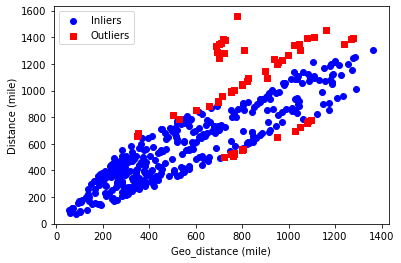

In [50]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor()
kfold = KFold(n_splits=5, shuffle = False)

cv_results = cross_validate(ransac, X_train, y_train, cv = kfold, scoring='neg_mean_squared_error')
cv_scores = cv_results['test_score']
print(cv_scores)
print(np.mean(cv_scores), np.std(cv_scores))

final_ransac = ransac.fit (X_train, y_train)

y_train_pred2 = final_ransac.predict(X_train)
y_test_pred2 = final_ransac.predict(X_test)

train_r22 = round(r2_score(y_train, y_train_pred2), 2)
test_r22= round(r2_score(y_test, y_test_pred2), 2)
print('train R2:', train_r22)
print('test R2: ', test_r22)

ransac = RANSACRegressor()
X = df['geo_distance'].values.reshape(-1, 1)
y = df['distance'].values.reshape(-1, 1)
final_ransac = ransac.fit(X, y)

inlier_mask = final_ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(0,5000,1)
line_y = final_ransac.predict(line_X.reshape(-1,1))

plt.scatter(x=X[inlier_mask], y=y[inlier_mask], c='blue', marker='o', label='Inliers')
plt.scatter(x=X[outlier_mask], y=y[outlier_mask], c='red', marker='s', label='Outliers')
plt.legend(['Inliers', 'Outliers'])
plt.xlabel('Geo_distance (mile)')
plt.ylabel('Distance (mile)')

In [ ]:
X = unavailable['geo_distance'].values.reshape(-1,1)
prediction = final_ransac.predict(X)
unavailable['distance2'] = prediction

In [ ]:
unavailable.head()

In [52]:
from sklearn.datasets import make_regression


In [53]:
X, y = make_regression(n_samples=100, n_features=1, tail_strength=0.9, effective_rank=1, n_informative=1, noise=3, bias=50, random_state=1)


In [55]:
y

array([57.0517663 , 48.42218204, 50.47606744, 47.60846577, 61.6446361 ,
       41.22141214, 49.55000903, 42.23665579, 59.34578282, 33.33575253,
       55.12857862, 52.28333222, 56.52409377, 49.67193048, 39.0461615 ,
       59.11744774, 37.72760565, 44.10715536, 55.92015679, 33.04053329,
       59.72871727, 43.28467911, 49.09540002, 56.94990419, 40.55446577,
       53.24817731, 55.02070364, 56.75085001, 30.25662405, 43.35485364,
       54.09622186, 49.10467524, 40.8371641 , 50.37902043, 56.83162571,
       63.32469357, 45.02251355, 52.50329906, 51.71362968, 35.57297634,
       73.86375694, 40.80125441, 59.81317854, 30.6886221 , 33.43192021,
       62.46987075, 65.69985088, 55.00578879, 41.15421864, 53.10676304,
       41.41398472, 55.9100712 , 39.66401285, 43.26898328, 49.29666758,
       59.57236305, 48.31450304, 60.28447753, 53.48098645, 50.956169  ,
       46.45098715, 40.82509086, 36.5482466 , 47.16007302, 47.28856914,
       51.62795842, 57.61576866, 57.60449649, 43.02675632, 61.45

In [59]:
from random import randint
from random import random


In [64]:
for i in range(10):
    factor = randint(2, 4)
    if random() > 0.5:
        print(random(), factor)
        X[i] += factor * X.std()
    else:
        X[i] -= factor * X.std()



0.7669084975405019 3
0.9674340896279304 2
0.13951758061777098 2
0.40127460974795315 2
0.7368773593336865 2
0.44714973496513055 3


In [65]:
print(len(X), len(y))

100 100
